## Project

This project explores whether we can **reasonably predict a developer’s annual compensation**
using self-reported survey data from the 2025 Stack Overflow Developer Survey.

#### Project motivations:
- I would like to understand how coding experience, programming language, years of coding experience, education level, and job positions affect the salary of developers.
- I also wonder if it is possible to predict the salary using these factors.

## Section 1: Business Understanding
#### The project aim to answer below questions.
- How does the coding experience influence salary of developer?
- How does the role affect the salary of developers?
- Does developer salary vary with country?
- Would education level change the salary of developers?
- Which language has highest salary?
- Can we train a Random Forest Model to predict salary using selected features?

In [522]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import os
import joblib

pd.set_option("display.max_columns", 50)

## Section 2: Data Understanding

#### Step 1. Gather

- Source: 2025 Stack Overflow Developer Survey (ODbL license)
- Respondents: 49,000+ responses from 177 countries
- Data type: Self-reported survey responses

In [523]:
DATA_PATH = "../data/raw/survey_results_public.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)

(49191, 172)


C:\Users\witch\AppData\Local\Temp\ipykernel_18080\2350051872.py:3: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


In [524]:
df.head()

,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,YearsCode,DevType,OrgSize,ICorPM,RemoteWork,PurchaseInfluence,TechEndorseIntro,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,...,AIAgentChange,AIAgent_Uses,AgentUsesGeneral,AIAgentImpactSomewhat agree,AIAgentImpactNeutral,AIAgentImpactSomewhat disagree,AIAgentImpactStrongly agree,AIAgentImpactStrongly disagree,AIAgentChallengesNeutral,AIAgentChallengesSomewhat disagree,AIAgentChallengesStrongly agree,AIAgentChallengesSomewhat agree,AIAgentChallengesStrongly disagree,AIAgentKnowledge,AIAgentKnowWrite,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,14.0,"Developer, mobile",20 to 99 employees,People manager,Remote,"Yes, I influenced the purchase of a substantia...",Work,10.0,7.0,9.0,6.0,3.0,11.0,12.0,...,Not at all or minimally,Software engineering,NaN,AI agents have increased my productivity.;AI a...,AI agents have helped me automate repetitive t...,NaN,NaN,NaN,I am concerned about the accuracy of the infor...,Integrating AI agents with my existing tools a...,The cost of using certain AI agent platforms i...,NaN,NaN,NaN,NaN,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,10.0,"Developer, back-end",500 to 999 employees,Individual contributor,"Hybrid (some in-person, leans heavy to flexibi...",No,Personal Project,13.0,1.0,2.0,9.0,4.0,3.0,12.0,...,Not at all or minimally,NaN,NaN,NaN,NaN,NaN,NaN,NaN,It takes significant time and effort to learn ...,NaN,I am concerned about the accuracy of the infor...,Integrating AI agents with my existing tools a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Technical ...,12.0,"Developer, front-end",NaN,NaN,NaN,No,Work,12.0,2.0,3.0,7.0,5.0,10.0,13.0,...,"Yes, somewhat",Software engineering,Multi-platform search enablement,AI agents have increased my productivity.;AI a...,AI agents have improved the quality of my code...,AI agents have improved collaboration within m...,NaN,NaN,It takes significant time and effort to learn ...,My company's IT and/or InfoSec teams have stri...,NaN,I am concerned about the accuracy of the infor...,NaN,Redis,NaN,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Videos (no...,5.0,"Developer, back-end","10,000 or mor

In [525]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49191 entries, 0 to 49190
Columns: 172 entries, ResponseId to JobSat
dtypes: float64(52), int64(1), object(119)
memory usage: 64.6+ MB


#### Step 2. Select the relevant features and the target

- Years of professional coding experience
- Country
- Primary developer role
- Primary programming language
- Education level
- Annual compensation (USD, normalized by Stack Overflow)

In [526]:
columns = [
    "ConvertedCompYearly",
    "YearsCode",
    "Country",
    "DevType",
    "LanguageHaveWorkedWith",
    "EdLevel"
]

df = df[columns]
df.head()

,ConvertedCompYearly,YearsCode,Country,DevType,LanguageHaveWorkedWith,EdLevel
0,61256.0,14.0,Ukraine,"Developer, mobile",Bash/Shell (all shells);Dart;SQL,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"
1,104413.0,10.0,Netherlands,"Developer, back-end",Java,"Associate degree (A.A., A.S., etc.)"
2,53061.0,12.0,Ukraine,"Developer, front-end",Dart;HTML/CSS;JavaScript;TypeScript,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)"
3,36197.0,5.0,Ukraine,"Developer, back-end",Java;Kotlin;SQL,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)"
4,60000.0,22.0,Ukraine,Engineering manager,C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"


## Section 3: Data Preparation

#### Step 1. Remove the invalid data for the target
- Exam the missing values of salary.
- As the data is self-reported, it is hard to make assumpsion of the missing values. All none data is discarded.

In [527]:
df = df.rename(columns={"ConvertedCompYearly": "salary"})
salary = df["salary"]
print("Total records:", len(salary))
print("Missing values:", salary.isna().sum())
print("Missing ratio:", salary.isna().mean())

Total records: 49191
Missing values: 25244
Missing ratio: 0.5131833058892887


In [528]:
# Remove none values
df = df[df["salary"].notna()]

- Exam the invalid values (<=0) of salary. All data are valid.

In [529]:
print("Non-positive salaries:", len(salary[salary <= 0]))

Non-positive salaries: 0


#### Step 2: Remove the outliers of the target data

##### 2.1 Observe the extreme values of salary
- Exam the outliers of the data.
- From the percentile analysis, 5% of salary is below 2724.8 and 99% of salary is below 440,856.

In [530]:
print("Statisical descriptions:")
print(salary.describe())
print("Percentiles:")
print(salary.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

Statisical descriptions:
count    2.394700e+04
mean     1.017615e+05
std      4.617569e+05
min      1.000000e+00
25%      3.817100e+04
50%      7.532000e+04
75%      1.205960e+05
max      5.000000e+07
Name: salary, dtype: float64
Percentiles:
0.01        65.0
0.05      2724.8
0.25     38171.0
0.50     75320.0
0.75    120596.0
0.95    232029.0
0.99    440856.0
Name: salary, dtype: float64


##### 2.2 Observe the salary data distribution

- The bin distribution graph shows long tailing on both sides.
- Majority data are between 1000 and 1000.
- The extremely low (<1000) and high (>1000,000) salary data accounts for <2% and are removed as outliers.
- After remove the extreme data, the data distribution is still left skewed but does not show obvious outliers.

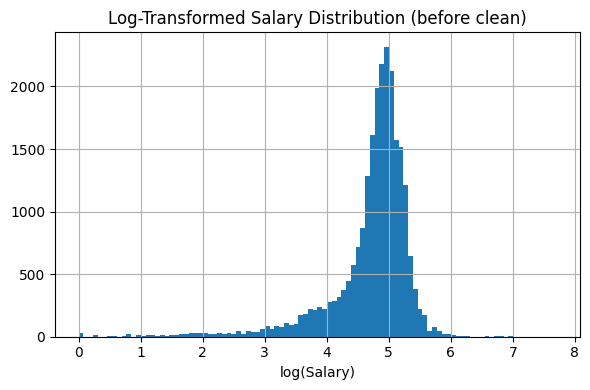

In [531]:
log_salary = np.log10(df["salary"])
plt.figure(figsize=(6, 4))
log_salary.hist(bins=100)
plt.title("Log-Transformed Salary Distribution (before clean)")
plt.xlabel("log(Salary)")
plt.tight_layout()
plt.show()

In [532]:
print("Count of extreme low values counts: ", len(salary[salary <= 1000]))
print("Count of extreme low values %: ", len(salary[salary <= 1000])/len(salary))
print("Count of extreme high values counts: ", len(salary[salary >= 1000_000]))
print("Count of extreme low values %: ", len(salary[salary >= 1000_000])/len(salary))

Count of extreme low values counts:  741
Count of extreme low values %:  0.015063731170336037
Count of extreme high values counts:  54
Count of extreme low values %:  0.0010977617856925048


In [533]:
df = df[
    (df["salary"] > 1000) &
    (df["salary"] < 1000_000)
]

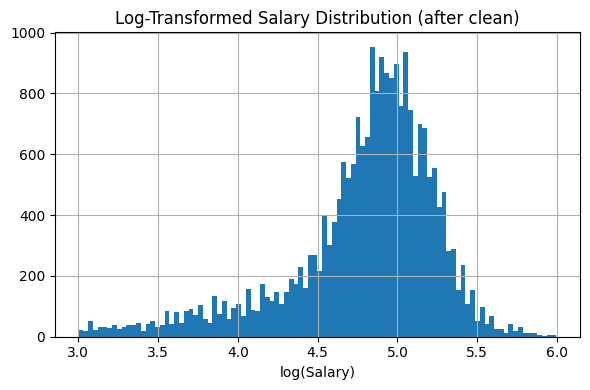

In [534]:
log_salary = np.log10(df["salary"])
plt.figure(figsize=(6, 4))
log_salary.hist(bins=100)
plt.title("Log-Transformed Salary Distribution (after clean)")
plt.xlabel("log(Salary)")
plt.tight_layout()
plt.show()

#### Step 3. Convert data type and clean the data

##### 3.1 Transform the numeric data
- Coding experience is transformed to numerical data with unit of Years.
- The invalid data (non-numerical) is < 1% and removed.

In [535]:
df["YearsCode"] = pd.to_numeric(
    df["YearsCode"], errors="coerce"
)
print("Invalid value %: ", df["YearsCode"].isna().mean())

Invalid value %:  0.0038873531444367656


In [536]:
df = df[df["YearsCode"].notna()]

##### 3.2 Transform the categorical data - select primary value for multiple inputs
- The programming languages and roles took multiple answers. The first answer is selected as primary value.

In [537]:
def first_item(x):
    """
    return the first word of a splited list of the text

    input:
        x: a string including several words seperated by ";"
    output:
        The first word from the splited list of the input text
    """
    if pd.isna(x):
        return np.nan
    return x.split(";")[0]

# Choose the first language from "LanguageHaveWorkedWith" as the primary language
df["PrimaryLanguage"] = df["LanguageHaveWorkedWith"].apply(first_item)

# Choose the first role from "DevType" as the primary role
df["PrimaryRole"] = df["DevType"].apply(first_item)

df = df.drop(columns=["LanguageHaveWorkedWith", "DevType"])
df.head()

,salary,YearsCode,Country,EdLevel,PrimaryLanguage,PrimaryRole
0,61256.0,14.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Bash/Shell (all shells),"Developer, mobile"
1,104413.0,10.0,Netherlands,"Associate degree (A.A., A.S., etc.)",Java,"Developer, back-end"
2,53061.0,12.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Dart,"Developer, front-end"
3,36197.0,5.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Java,"Developer, back-end"
4,60000.0,22.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",C,Engineering manager


##### 3.3 Transform the categorical data - remove the missing data
- Exam the missing values in each column and noticed that 16 responses missed education level and 1621 responses missed programing language. 
- The total missing values accounts for 1.2% of the data and is discarded.

In [538]:
# Count missing values in each column before dropping
print("Missing values per column before drop:")
print(df.isna().sum())
print(f"\nTotal missing values: {(df.isna().sum().sum())/df.count().sum()}")

Missing values per column before drop:
salary                0
YearsCode             0
Country               0
EdLevel              16
PrimaryLanguage    1621
PrimaryRole           0
dtype: int64

Total missing values: 0.011972062749113247


In [539]:
# Drop rows with any NaN values
df = df.dropna()

print(f"\nShape after dropping NaN: {df.shape}")


Shape after dropping NaN: (21427, 6)


#### Step 4. Save the cleaned data

In [540]:
df.to_csv("../data/processed/survey_results_salary_prediction.csv")

## Section 4 & 5: Data Modeling and Evaluation

### Step 1. Data Analysis

#### Question 1: How does the coding experience influence salary of developer?
- To answer this question, a scatter plot is created to observe the correlation between salary and years of coding experience.
- Salary increases with years of coding experience.
- However, data is in wide range of variance, suggesting other factors also matter.

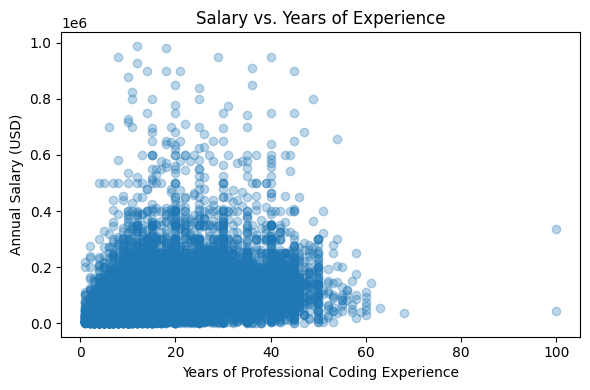

In [541]:
# Explore the effect of Coding experience on the Salary

plt.figure(figsize=(6, 4))
plt.scatter(df["YearsCode"], df["salary"], alpha=0.3)
plt.xlabel("Years of Professional Coding Experience")
plt.ylabel("Annual Salary (USD)")
plt.title("Salary vs. Years of Experience")

plt.tight_layout()
plt.savefig("../reports/figures/salary_vs_experience.png", dpi=150)
plt.show()

#### Question 2: How does the role affect the salary of developers?
- To answer this question, a boxplot graph is created to observe the salary distributions for each role.
- Architect, software or solutions, has highest median salary than other roles.
- Each role has many outliers on top salary range. This could be due to other reasons, such as country, experience, etc.

C:\Users\witch\AppData\Local\Temp\ipykernel_18080\59729662.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  role_subset["RoleAbbr"] = role_subset["PrimaryRole"].map(abbreviation_map)
C:\Users\witch\AppData\Local\Temp\ipykernel_18080\59729662.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  role_subset["RoleAbbr"] = pd.Categorical(


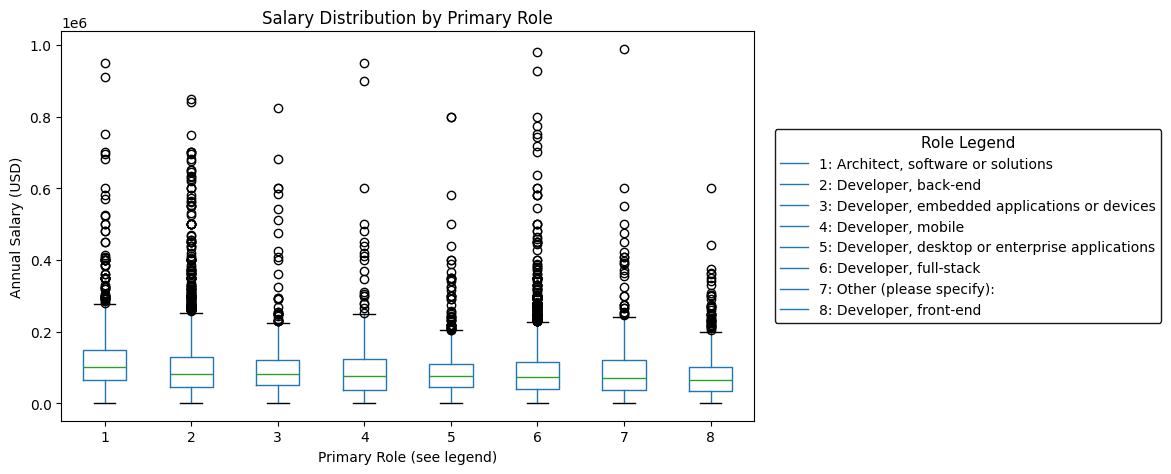

In [542]:
# Salary distribution by roles (for the 8 most reported role type)

top_roles = (
    df["PrimaryRole"]
    .value_counts()
    .head(8)
    .index
)

role_subset = df[df["PrimaryRole"].isin(top_roles)]

# Calculate median salary for each role and sort in descending order
median_salaries = role_subset.groupby("PrimaryRole")["salary"].median().sort_values(ascending=False)

# Get roles in order of decreasing median salary
roles_ordered_by_median = median_salaries.index.tolist()

# Create abbreviation mapping
abbreviation_map = {role: str(i+1) for i, role in enumerate(roles_ordered_by_median)}

# Create a temporary column with abbreviations
role_subset["RoleAbbr"] = role_subset["PrimaryRole"].map(abbreviation_map)

# Make RoleAbbr categorical to maintain order
role_subset["RoleAbbr"] = pd.Categorical(
    role_subset["RoleAbbr"], 
    categories=[abbreviation_map[r] for r in roles_ordered_by_median], 
    ordered=True
)

# Create figure with adjusted width to accommodate legend
fig, ax = plt.subplots(figsize=(14, 5))

role_subset.boxplot(
    column="salary",
    by="RoleAbbr",
    grid=False,
    ax=ax
)

plt.title("Salary Distribution by Primary Role")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("Primary Role (see legend)")

# Remove the default "by RoleAbbr" subtitle
ax.get_figure().suptitle('')

# Create legend text
legend_text = [f"{i+1}: {role}" for i, role in enumerate(roles_ordered_by_median)]

# Create legend on the right side
legend = ax.legend(legend_text, 
                   title="Role Legend",
                   title_fontsize=11,
                   fontsize=10,
                   loc='center left', 
                   bbox_to_anchor=(1.02, 0.5),
                   frameon=True,
                   framealpha=0.9,
                   edgecolor='black',
                   fancybox=True)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig("../reports/figures/salary_by_role.png", dpi=150, bbox_inches='tight')
plt.show()

#### Question 3: Does developer salary vary with country?
- To answer this question, a boxplot graph is created to compare salaries from different countries.
- Developers from United States have highest median salaries compared to other countries.
- Each country has many outliers on top salary range due to other reasons, such as experience, role, etc.

C:\Users\witch\AppData\Local\Temp\ipykernel_18080\1682956393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_subset["CountryAbbr"] = country_subset["Country"].map(abbreviation_map)
C:\Users\witch\AppData\Local\Temp\ipykernel_18080\1682956393.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_subset["CountryAbbr"] = pd.Categorical(


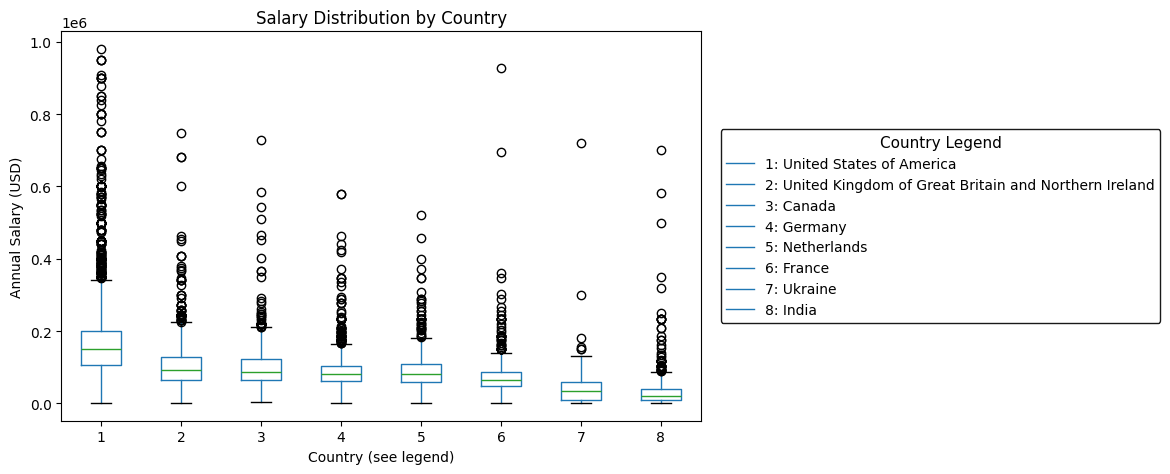

In [543]:
# Salary distribution by country (for the 8 most reported countries)
top_countries = (
    df["Country"]
    .value_counts()
    .head(8)
    .index
)

country_subset = df[df["Country"].isin(top_countries)]

# Calculate median salary for each country and sort in descending order
median_salaries = country_subset.groupby("Country")["salary"].median().sort_values(ascending=False)

# Get countries in order of decreasing median salary
country_ordered_by_median = median_salaries.index.tolist()

# Create abbreviation mapping
abbreviation_map = {country: str(i+1) for i, country in enumerate(country_ordered_by_median)}

# Create a temporary column with abbreviations
country_subset["CountryAbbr"] = country_subset["Country"].map(abbreviation_map)

# Make CountryAbbr categorical to maintain order
country_subset["CountryAbbr"] = pd.Categorical(
    country_subset["CountryAbbr"], 
    categories=[abbreviation_map[c] for c in country_ordered_by_median], 
    ordered=True
)

# Create figure with adjusted width to accommodate legend
fig, ax = plt.subplots(figsize=(14, 5))

country_subset.boxplot(
    column="salary",
    by="CountryAbbr",
    grid=False,
    ax=ax
)

plt.title("Salary Distribution by Country")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("Country (see legend)")

# Remove the default "by CountryAbbr" subtitle
ax.get_figure().suptitle('')

# Create legend text
legend_text = [f"{i+1}: {country}" for i, country in enumerate(country_ordered_by_median)]

# Create legend on the right side
legend = ax.legend(legend_text, 
                   title="Country Legend",
                   title_fontsize=11,
                   fontsize=10,
                   loc='center left', 
                   bbox_to_anchor=(1.02, 0.5),
                   frameon=True,
                   framealpha=0.9,
                   edgecolor='black',
                   fancybox=True)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig("../reports/figures/salary_by_country.png", dpi=150, bbox_inches='tight')
plt.show()

#### Questions 4: Would education level change the salary of developers?
- To answer this question, a boxplot graph is created to compare salaries of develops with different educations.
- The median salary ranking follows the order of Professional > Master's > Bachelor's > Associate > Others.
- However, the difference between education levels is quite small.
- The education levels above college or secondary school level have many outliers in high salary range. The graduate degree didn't show obvious benefits than college degree.

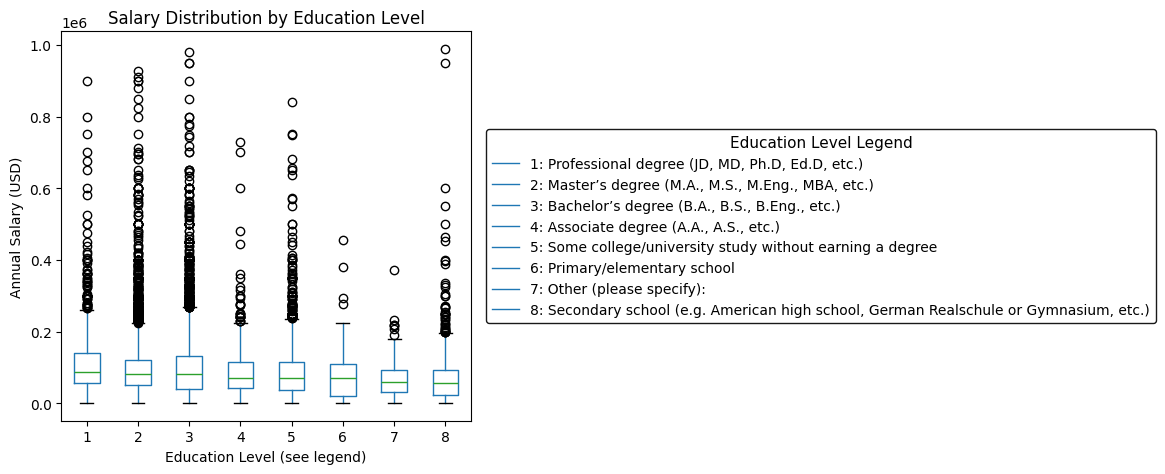

In [544]:
# Salary distribution by education level (for the 8 most reported education levels)
top_edu = (
    df["EdLevel"]
    .value_counts()
    .head(8)
    .index
)

edu_subset = df[df["EdLevel"].isin(top_edu)]

# Calculate median salary for each education level and sort in descending order
median_salaries = edu_subset.groupby("EdLevel")["salary"].median().sort_values(ascending=False)

# Get education levels in order of decreasing median salary
edu_ordered_by_median = median_salaries.index.tolist()

# Create abbreviation mapping
abbreviation_map = {edu: str(i+1) for i, edu in enumerate(edu_ordered_by_median)}

# Create a temporary column with abbreviations
edu_subset["EdLevelAbbr"] = edu_subset["EdLevel"].map(abbreviation_map)

# Make EdLevelAbbr categorical to maintain order
edu_subset["EdLevelAbbr"] = pd.Categorical(
    edu_subset["EdLevelAbbr"], 
    categories=[abbreviation_map[e] for e in edu_ordered_by_median], 
    ordered=True
)

# Create figure with adjusted width to accommodate legend
fig, ax = plt.subplots(figsize=(14, 5))  # Increased from (6, 2) to make room for legend

edu_subset.boxplot(
    column="salary",
    by="EdLevelAbbr",
    grid=False,
    ax=ax
)

plt.title("Salary Distribution by Education Level")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("Education Level (see legend)")

# Remove the default "by EdLevelAbbr" subtitle
ax.get_figure().suptitle('')

# Create legend text
legend_text = [f"{i+1}: {edu}" for i, edu in enumerate(edu_ordered_by_median)]

# Create legend on the right side
legend = ax.legend(legend_text, 
                   title="Education Level Legend",
                   title_fontsize=11,
                   fontsize=10,
                   loc='center left', 
                   bbox_to_anchor=(1.02, 0.5),  # Position to the right of the plot
                   frameon=True,
                   framealpha=0.9,
                   edgecolor='black',
                   fancybox=True)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave 15% space on the right for legend

plt.savefig("../reports/figures/salary_by_education.png", dpi=150, bbox_inches='tight')
plt.show()

#### Question 5: Which language has highest salary?
- To answer this question, a boxplot graph is created to compare salaries across different programming languages.
- The median salary ranking follows the order of Go > Bash/Shell > C# > Java > Others
- The difference between languages is very small. 
- All languages have outliers in high salary ranges. The Bash/Shell and Assembly have highest outliers than others, possibly due to a demand in specific expertise.

C:\Users\witch\AppData\Local\Temp\ipykernel_18080\841397439.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lang_subset["PrimaryLanguage"] = pd.Categorical(


<Figure size 600x200 with 0 Axes>

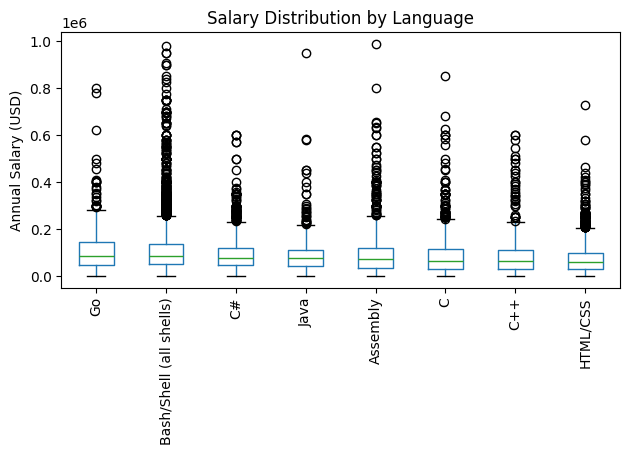

In [545]:
#Salary distribution by language

top_lang = (
    df["PrimaryLanguage"]
    .value_counts()
    .head(8)
    .index
)

lang_subset = df[df["PrimaryLanguage"].isin(top_lang)]

median_salaries = lang_subset.groupby("PrimaryLanguage")["salary"].median().sort_values(ascending=False)
lang_ordered_by_median = median_salaries.index.tolist()
lang_subset["PrimaryLanguage"] = pd.Categorical(
    lang_subset["PrimaryLanguage"], 
    categories=lang_ordered_by_median, 
    ordered=True
)

plt.figure(figsize=(6, 2))
lang_subset.boxplot(
    column="salary",
    by="PrimaryLanguage",
    rot=90,
    grid=False
)

plt.title("Salary Distribution by Language")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_language.png", dpi=150)
plt.show()

#### Question 6: Can we train a Random Forest Model to predict salary using selected features?

#### Step 1. Prepare the training and testing datasets

- Split dataset to 80/20 train-test

In [546]:
X = df.drop(columns="salary")
y = df["salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Step 2. One-hot encoding categorical data
- One-hot encoding is used to transform categorical features.
- Because the categorical features are nominal variables, one-hot encoding provides an interpretable way to represent them. With one-hot encoding, each categorical variable is transformed into multiple binary variables, without introducing artificial ordering or distance between categories.

In [547]:
categorical_features = [
    "Country",
    "PrimaryRole",
    "PrimaryLanguage",
    "EdLevel"
]

numeric_features = ["YearsCode"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

#### Step 3. Select the model and set up the hyperparameters

- Set up the hyperparameters for a random forest model.
- The parameters were choosed for general purpose. A value of 100 trees offers reliable performance without excessive computational cost. A maximum depth of 12 limits model complexity while allowing trees to capture non-linear relationship and reducing overfitting. 

In [548]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    random_state=42
)

#### Step 4. Train the model and save it
- Set up pipeline to take categorical and numeric features and train the model.

In [549]:
pipeline = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", model)
    ]
)

In [550]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Country', 'PrimaryRole',
                                                   'PrimaryLanguage',
                                                   'EdLevel']),
                                                 ('num', 'passthrough',
                                                  ['YearsCode'])])),
                ('model',
                 RandomForestRegressor(max_depth=12, random_state=42))])

In [551]:
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "salary_rf_pipeline.joblib")
joblib.dump(pipeline, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ../models\salary_rf_pipeline.joblib


#### Step 5. Evaluate the model

##### 5.1 Model error and R2
- Calculate the mean absolute error to estimate the error range.
- Calculate the R2 to evaluate model's predictive power.

In [552]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:,.0f}")
print(f"R²: {r2:.2f}")

MAE: $38,511
R²: 0.39


Model performance

- **Mean Absolute Error (MAE):** ~$38,511
- **R² Score:** ~0.39

Interpretation:
- Predictions are often within ~$39k of reported salary.
- Roughly 40% of salary variance is explained by the model.
- The 60% of unexplained variance could be due to missing factors, such as network, negotiation skills.

##### 5.2 Compare predictive values to true values

- The predicted value is aligned with true values in low salary range (<400,000).
- The model underpredicted the high salary range (>=400,000). There could be other factors contribute to the high salary.

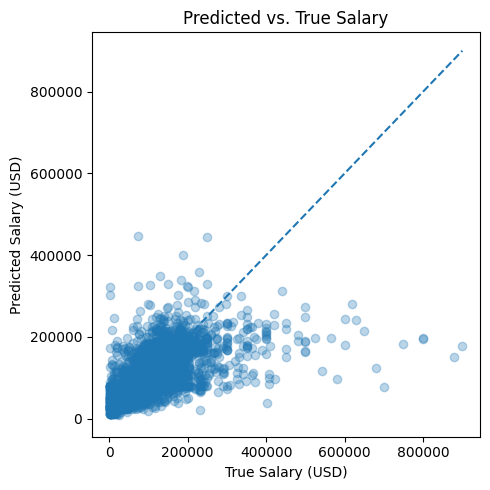

In [553]:
# Draw a dotted plot to check predicted values vs true values for the salary

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)

plt.xlabel("True Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Predicted vs. True Salary")

plt.tight_layout()
plt.savefig("../reports/figures/predicted_vs_true.png", dpi=150)
plt.show()

#### 5.3 Rank the importance of features
- Country is the strongest factor. It explains about 48% of the model's predictive power.
- Years of coding experience is the second strongest factor, explaining about 26% of the model's predictive power.
- Professional role explains about 13% of the model's predictive power.
- The programming language and education level have small influence, with each one explaining less than 10% of the model's predictive power.

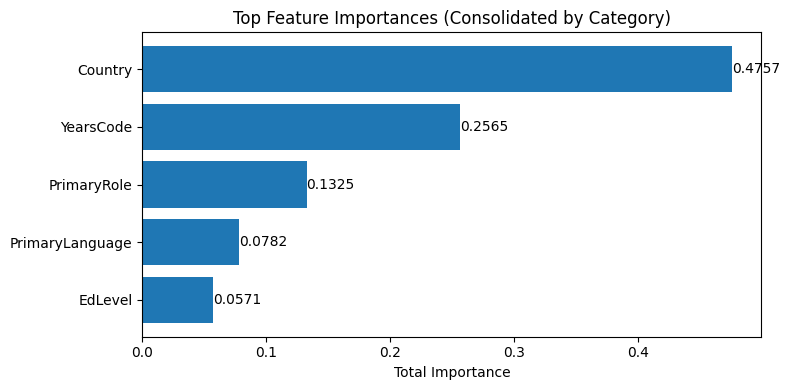

Detailed breakdown of top categories:

Country: 0.4757
  - United States of America: 0.3687
  - Switzerland: 0.0256
  - United Kingdom of Great Britain and Northern Ireland: 0.0144
  - Canada: 0.0089
  - Israel: 0.0081
  ... and 150 more values

YearsCode: 0.2565
  (single feature)

PrimaryRole: 0.1325
  - Developer, back-end: 0.0169
  - Senior executive (C-suite, VP, etc.): 0.0165
  - Engineering manager: 0.0102
  - Developer, full-stack: 0.0099
  - Academic researcher: 0.0086
  ... and 27 more values

PrimaryLanguage: 0.0782
  - Bash/Shell (all shells): 0.0114
  - Assembly: 0.0084
  - C++: 0.0084
  - C: 0.0073
  - Go: 0.0062
  ... and 32 more values

EdLevel: 0.0571
  - Master’s degree (M.A., M.S., M.Eng., MBA, etc.): 0.0149
  - Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.): 0.0112
  - Bachelor’s degree (B.A., B.S., B.Eng., etc.): 0.0097
  - Some college/university study without earning a degree: 0.0078
  - Professional degree (JD, MD, Ph.D, Ed.D,

In [554]:
# Get OneHotEncoder from pipeline
ohe = pipeline.named_steps["prep"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out()

feature_names = list(cat_features) + ["YearsCode"]
importances = pipeline.named_steps["model"].feature_importances_

# Create initial DataFrame
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Consolidate categorical features with same prefix
consolidated_data = []

# Separate categorical (with '_') from non-categorical features
for feature, importance in zip(fi["feature"], fi["importance"]):
    if '_' in feature:
        # Split by first '_' to get category and value
        parts = feature.split('_', 1)
        category = parts[0]  # e.g., "Country"
        # value = parts[1]   # e.g., "United States" - not needed for consolidation
        consolidated_data.append({
            "category": category,
            "feature": feature,
            "importance": importance
        })
    else:
        # Non-categorical feature (like "YearsCode")
        consolidated_data.append({
            "category": feature,  # Use full feature name as category
            "feature": feature,
            "importance": importance
        })

# Create DataFrame
consolidated_df = pd.DataFrame(consolidated_data)

# Group by category and sum importances
category_importance = (
    consolidated_df
    .groupby("category")
    .agg({
        "importance": "sum",
        "feature": lambda x: list(x)  # Keep track of original features
    })
    .reset_index()
    .rename(columns={"importance": "total_importance"})
    .sort_values("total_importance", ascending=False)
)

# Get top 15 categories
top_categories = category_importance.head(15)

# Plot
plt.figure(figsize=(8, 4))
bars = plt.barh(top_categories["category"], top_categories["total_importance"])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Consolidated by Category)")
plt.xlabel("Total Importance")

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}',
             ha='left', va='center')

plt.tight_layout()
plt.savefig("../reports/figures/feature_importance_consolidated.png", dpi=150)
plt.show()

# Also show the detailed breakdown for top categories
print("Detailed breakdown of top categories:")
for idx, row in top_categories.iterrows():
    category = row["category"]
    total_imp = row["total_importance"]
    features = row["feature"]
    
    print(f"\n{category}: {total_imp:.4f}")
    
    # Get detailed importances for each feature in this category
    if len(features) > 1:  # Only show breakdown for actual categories with multiple features
        category_features = fi[fi["feature"].str.startswith(f"{category}_")]
        if len(category_features) > 0:
            # Sort individual features by importance
            sorted_features = category_features.sort_values("importance", ascending=False)
            for _, feat_row in sorted_features.head(5).iterrows():  # Show top 5 values
                feat_name = feat_row["feature"].split('_', 1)[1]  # Get value after '_'
                print(f"  - {feat_name}: {feat_row['importance']:.4f}")
            
            if len(sorted_features) > 5:
                remaining = len(sorted_features) - 5
                print(f"  ... and {remaining} more values")
    else:
        # For non-categorical features like "YearsCode"
        print(f"  (single feature)")

### Conclusions
 - The major factors to influence developer salary are country and coding experience, together explaining about 75% of model's predictive power.
 - The RF model can explain roughly 40% of salary variance. It underestimated the salary for high value range (>400,000), possibly due to missing other factors.

 ### Business question summary
How does the coding experience influence salary of developer?
- Salary increases with years of coding experience. However, data is in wide range of variance, suggesting other factors also matter.

How does the role affect the salary of developers?
- Architect, software or solutions, has highest median salary than other roles.
- However, each role has many outliers on top salary range. This could be due to other reasons, such as country, experience, etc.

Does developer salary vary with country?
- Developers from United States have highest median salaries compared to other countries.
- Each country has many outliers on top salary range due to other reasons, such as experience, role, etc.

Would education level change the salary of developers?
- The median salary ranking follows the order of Professional > Master's > Bachelor's > Associate > Others.
- However, the difference between education levels is quite small.
- The education levels above college or secondary school level have many outliers in high salary range. The graduate degree didn't show obvious benefits than college degree.

Which language has highest salary?
- The median salary ranking follows the order of Go > Bash/Shell > C# > Java > Others
- The difference between languages is very small. 
- All languages have outliers in high salary ranges. The Bash/Shell and Assembly have highest outliers than others, possibly due to a demand in specific expertise.

Can we train a Random Forest Model to predict salary using selected features?
- The model can explain roughly 40% of salary and predictions are often within ~$39k of reported salary.
- The predicted value is aligned with true values in low salary range (<400,000). It underpredicted the high salary range (>=400,000), suggesting other factors may contribute to a high salary.
- The analysis of feature importance suggests that Country is the dominating factor in this model. It explains almost half of the model's predictive power. The next important factor is the coding experience, which explains about 26% of the predict power. Other factors are less important.

##### Limitations:
- The data is self-reported and may not be accurate.
- Model prediction power is limited (R²=0.39). The model underpredict the salary in high value range, possibly due to missing other important factors, such as network, negotiation skills, etc.